# Ruler Tenure Analysis

Does violent accession predict shorter reigns? Testing whether instability begets instability.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

Path("figures").mkdir(exist_ok=True)
sns.set_style("whitegrid")

In [2]:
crisis = pd.read_csv("power_transitions.csv", sep="|")
print(f"Raw: {len(crisis):,} transitions")

Raw: 3,447 transitions


## Computing Reign Lengths

Reign = time from accession to next transition within same polity.

In [3]:
# Sort by polity and year
crisis = crisis.sort_values(['polity_new_ID', 'transition_year'])

# Compute reign length: next transition year - this transition year
crisis['next_year'] = crisis.groupby('polity_new_ID')['transition_year'].shift(-1)
crisis['reign_years'] = crisis['next_year'] - crisis['transition_year']

# Drop last ruler of each polity (no end date) and negative/zero reigns
df = crisis[crisis['reign_years'] > 0].copy()
print(f"Rulers with computed tenure: {len(df):,}")
print(f"Median reign: {df['reign_years'].median():.0f} years")
print(f"Mean reign: {df['reign_years'].mean():.1f} years")

Rulers with computed tenure: 2,889
Median reign: 9 years
Mean reign: 14.2 years


In [4]:
# Code accession violence
violence_cols = ['intra_elite', 'predecessor_assassination', 'military_revolt', 
                 'popular_uprising', 'contested']

for col in violence_cols:
    df[f"{col}_b"] = df[col].isin(['P', 'IP']).astype(int)

# Any violence at accession
df['violent_accession'] = df[[f"{c}_b" for c in violence_cols]].max(axis=1)

print(f"Violent accessions: {df['violent_accession'].sum():,} ({df['violent_accession'].mean()*100:.1f}%)")
print(f"Peaceful accessions: {(1-df['violent_accession']).sum():,}")

Violent accessions: 1,303 (45.1%)
Peaceful accessions: 1,586


## Hypothesis Test

**H1**: Violent accession → shorter reign

In [5]:
violent = df[df['violent_accession'] == 1]['reign_years']
peaceful = df[df['violent_accession'] == 0]['reign_years']

print("Reign length by accession type:")
print(f"  Violent:  median = {violent.median():.0f} yrs, mean = {violent.mean():.1f} yrs (n={len(violent)})")
print(f"  Peaceful: median = {peaceful.median():.0f} yrs, mean = {peaceful.mean():.1f} yrs (n={len(peaceful)})")

# Mann-Whitney U (non-parametric, skewed distributions)
u_stat, p_mw = stats.mannwhitneyu(violent, peaceful, alternative='less')
print(f"\nMann-Whitney U: p = {p_mw:.4f} (one-tailed)")

# Effect size: median difference
diff = peaceful.median() - violent.median()
print(f"Difference: {diff:.0f} years shorter median reign after violent accession")

Reign length by accession type:
  Violent:  median = 8 yrs, mean = 12.4 yrs (n=1303)
  Peaceful: median = 10 yrs, mean = 15.6 yrs (n=1586)

Mann-Whitney U: p = 0.0000 (one-tailed)
Difference: 2 years shorter median reign after violent accession


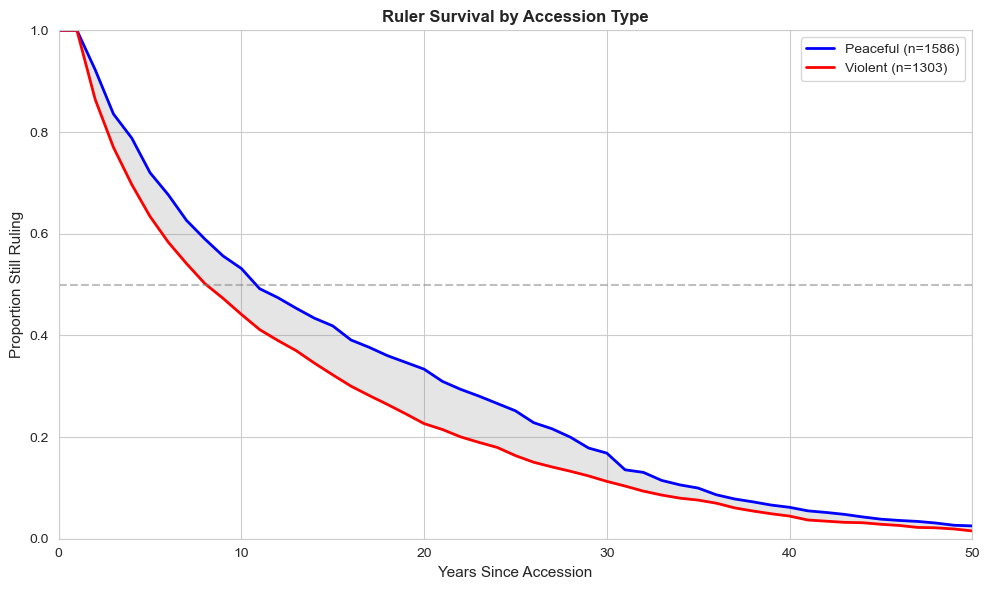

In [6]:
# Simple survival curves (proportion still ruling at year X)
max_years = 50
years = np.arange(0, max_years + 1)

def survival_curve(reigns, years):
    return [np.mean(reigns >= y) for y in years]

surv_violent = survival_curve(violent.values, years)
surv_peaceful = survival_curve(peaceful.values, years)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(years, surv_peaceful, 'b-', linewidth=2, label=f'Peaceful (n={len(peaceful)})')
ax.plot(years, surv_violent, 'r-', linewidth=2, label=f'Violent (n={len(violent)})')
ax.fill_between(years, surv_peaceful, surv_violent, alpha=0.2, color='gray')

ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Years Since Accession', fontsize=11)
ax.set_ylabel('Proportion Still Ruling', fontsize=11)
ax.set_title('Ruler Survival by Accession Type', fontsize=12, fontweight='bold')
ax.legend(loc='upper right')
ax.set_xlim(0, max_years)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('figures/04_survival_curves.png', dpi=150)
plt.show()

## Mechanism Breakdown

Which types of violent accession predict shortest reigns?

In [7]:
results = []
for col in violence_cols:
    yes = df[df[f"{col}_b"] == 1]['reign_years']
    no = df[df[f"{col}_b"] == 0]['reign_years']
    if len(yes) >= 10:  # minimum sample
        u, p = stats.mannwhitneyu(yes, no, alternative='less')
        results.append({
            'mechanism': col.replace('_', ' ').title(),
            'n': len(yes),
            'median_yes': yes.median(),
            'median_no': no.median(),
            'diff': no.median() - yes.median(),
            'p': p
        })

mech_df = pd.DataFrame(results).sort_values('diff', ascending=False)
print(mech_df.to_string(index=False))

                mechanism    n  median_yes  median_no  diff            p
          Military Revolt  348         6.0       10.0   4.0 3.630842e-06
              Intra Elite  864         7.0       10.0   3.0 6.491625e-11
                Contested 1129         7.0       10.0   3.0 7.432073e-11
         Popular Uprising  171         7.0        9.0   2.0 6.839679e-02
Predecessor Assassination  426         8.0        9.0   1.0 9.098885e-04


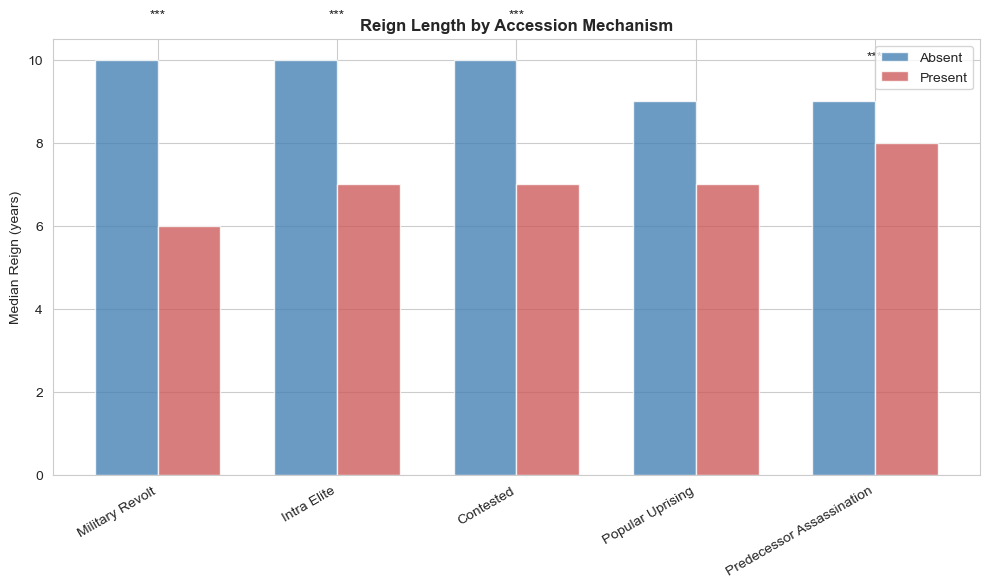

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

mechanisms = mech_df['mechanism'].values
x = np.arange(len(mechanisms))
width = 0.35

bars1 = ax.bar(x - width/2, mech_df['median_no'], width, label='Absent', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, mech_df['median_yes'], width, label='Present', color='indianred', alpha=0.8)

ax.set_ylabel('Median Reign (years)')
ax.set_title('Reign Length by Accession Mechanism', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(mechanisms, rotation=30, ha='right')
ax.legend()

# Add significance markers
for i, row in mech_df.reset_index(drop=True).iterrows():
    if row['p'] < 0.001:
        ax.text(i, max(row['median_yes'], row['median_no']) + 1, '***', ha='center', fontsize=10)
    elif row['p'] < 0.01:
        ax.text(i, max(row['median_yes'], row['median_no']) + 1, '**', ha='center', fontsize=10)
    elif row['p'] < 0.05:
        ax.text(i, max(row['median_yes'], row['median_no']) + 1, '*', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('figures/04_mechanism_tenure.png', dpi=150)
plt.show()

## Violence Begets Violence?

If predecessor was assassinated, is successor more likely to also be removed violently?

In [9]:
# Code exit violence (how they left power)
# Look at the NEXT row's predecessor_assassination for this ruler's exit
df['next_pred_assn'] = df.groupby('polity_new_ID')['predecessor_assassination_b'].shift(-1)
df['violent_exit'] = df['next_pred_assn'].fillna(0).astype(int)

# Only rulers where we know their exit
df_exits = df[df['next_pred_assn'].notna()].copy()

print(f"Rulers with known exit: {len(df_exits)}")
print(f"Violent exits: {df_exits['violent_exit'].sum()} ({df_exits['violent_exit'].mean()*100:.1f}%)")

# Crosstab
ct_raw = pd.crosstab(df_exits['violent_accession'], df_exits['violent_exit'])
print("\nEntry vs Exit Violence (counts):")
print(ct_raw)

# Rates
entry_exit = df_exits.groupby('violent_accession')['violent_exit'].agg(['sum', 'count', 'mean'])
entry_exit.index = ['Peaceful Entry', 'Violent Entry']
entry_exit.columns = ['Violent Exits', 'Total', 'Exit Violence Rate']
print("\nViolent exit rate by entry type:")
print(entry_exit.to_string())

# Chi-square (only if both categories exist)
if ct_raw.shape == (2, 2):
    chi2, p_chi, dof, expected = stats.chi2_contingency(ct_raw)
    print(f"\nChi-square: χ² = {chi2:.1f}, p = {p_chi:.4f}")
else:
    print("\nInsufficient variation for chi-square test")

Rulers with known exit: 2636
Violent exits: 396 (15.0%)

Entry vs Exit Violence (counts):
violent_exit          0    1
violent_accession           
0                  1330  132
1                   910  264

Violent exit rate by entry type:
                Violent Exits  Total  Exit Violence Rate
Peaceful Entry            132   1462            0.090287
Violent Entry             264   1174            0.224872

Chi-square: χ² = 91.3, p = 0.0000


## Complexity and Tenure

Do complex bureaucracies stabilize or destabilize rulers?

In [10]:
# Load Seshat admin levels
equinox = pd.ExcelFile("../data/Equinox_on_GitHub_June9_2022.xlsx")
polities = pd.read_excel(equinox, sheet_name="Polities")
seshat = pd.read_excel(equinox, sheet_name="Equinox2020_CanonDat")

hier = seshat[seshat['Subsection'] == 'Hierarchical Complexity'].copy()
hier['value'] = pd.to_numeric(hier['Value.From'], errors='coerce')
admin = hier[hier['Variable'] == 'Administrative levels'].groupby('Polity')['value'].mean().reset_index()
admin.columns = ['PolID', 'admin_levels']

polities['name_norm'] = polities['PolName'].str.lower().str.strip()
admin = admin.merge(polities[['PolID', 'name_norm']], on='PolID', how='left')

df['name_norm'] = df['polity_name'].str.lower().str.strip()
df_admin = df.merge(admin[['name_norm', 'admin_levels']], on='name_norm', how='left')
df_admin = df_admin[df_admin['admin_levels'].notna()]

print(f"Rulers with admin data: {len(df_admin):,}")

Rulers with admin data: 1,885


In [11]:
r, p = stats.pearsonr(df_admin['admin_levels'], df_admin['reign_years'])
print(f"Correlation: r = {r:.3f}, p = {p:.4f}")

# Binned comparison
df_admin['admin_bin'] = pd.cut(df_admin['admin_levels'], bins=[0, 3, 5, 7, 10], 
                                labels=['1-3', '4-5', '6-7', '8+'])
binned = df_admin.groupby('admin_bin', observed=True)['reign_years'].agg(['median', 'mean', 'count'])
print("\nReign by admin complexity:")
print(binned.to_string())

Correlation: r = -0.082, p = 0.0003

Reign by admin complexity:
           median       mean  count
admin_bin                          
1-3          12.0  15.584000    125
4-5           9.0  13.294393    642
6-7          10.0  14.148450    613
8+            8.0  11.267327    505


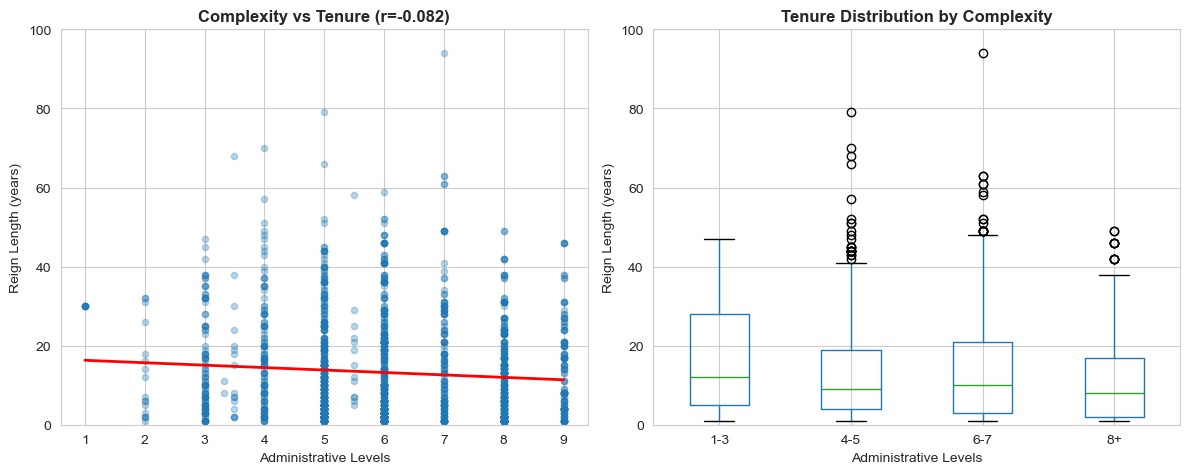

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter
ax = axes[0]
ax.scatter(df_admin['admin_levels'], df_admin['reign_years'], alpha=0.3, s=20)
z = np.polyfit(df_admin['admin_levels'], df_admin['reign_years'], 1)
p_line = np.poly1d(z)
x_line = np.linspace(df_admin['admin_levels'].min(), df_admin['admin_levels'].max(), 100)
ax.plot(x_line, p_line(x_line), 'r-', linewidth=2)
ax.set_xlabel('Administrative Levels')
ax.set_ylabel('Reign Length (years)')
ax.set_title(f'Complexity vs Tenure (r={r:.3f})', fontweight='bold')
ax.set_ylim(0, 100)  # Cap for visibility

# Boxplot by bin
ax = axes[1]
df_admin.boxplot(column='reign_years', by='admin_bin', ax=ax)
ax.set_xlabel('Administrative Levels')
ax.set_ylabel('Reign Length (years)')
ax.set_title('Tenure Distribution by Complexity', fontweight='bold')
ax.set_ylim(0, 100)
plt.suptitle('')  # Remove auto-generated title

plt.tight_layout()
plt.savefig('figures/04_complexity_tenure.png', dpi=150)
plt.show()

## Notable Polities

Which polities had the longest/shortest average reigns?

In [13]:
polity_stats = df.groupby('polity_name').agg(
    n_rulers=('reign_years', 'count'),
    median_reign=('reign_years', 'median'),
    mean_reign=('reign_years', 'mean'),
    violence_rate=('violent_accession', 'mean')
).reset_index()

polity_stats = polity_stats[polity_stats['n_rulers'] >= 10].sort_values('median_reign')

print("Shortest median reigns (n>=10):")
print(polity_stats.head(10).to_string(index=False))

print("\nLongest median reigns (n>=10):")
print(polity_stats.tail(10).to_string(index=False))

Shortest median reigns (n>=10):
                polity_name  n_rulers  median_reign  mean_reign  violence_rate
       Imamate of Futa Toro        35           1.0    1.371429       0.085714
           Interwar Austria        10           1.5    1.800000       0.900000
Early United Mexican States        31           2.0    3.161290       0.645161
                Futa Jallon        38           2.0    3.157895       0.105263
       Ethiopia Kingdom III        23           2.0    3.565217       1.000000
 Egypt - Mamluk Sultanate I        16           2.0    5.625000       0.875000
                 Kievan Rus        43           3.0    8.279070       0.767442
      Five Dynasties Period        13           3.0    3.692308       0.846154
                Polonnaruwa        17           3.0   10.882353       0.941176
             Bamana kingdom        14           3.0    7.571429       0.357143

Longest median reigns (n>=10):
        polity_name  n_rulers  median_reign  mean_reign  violence_r

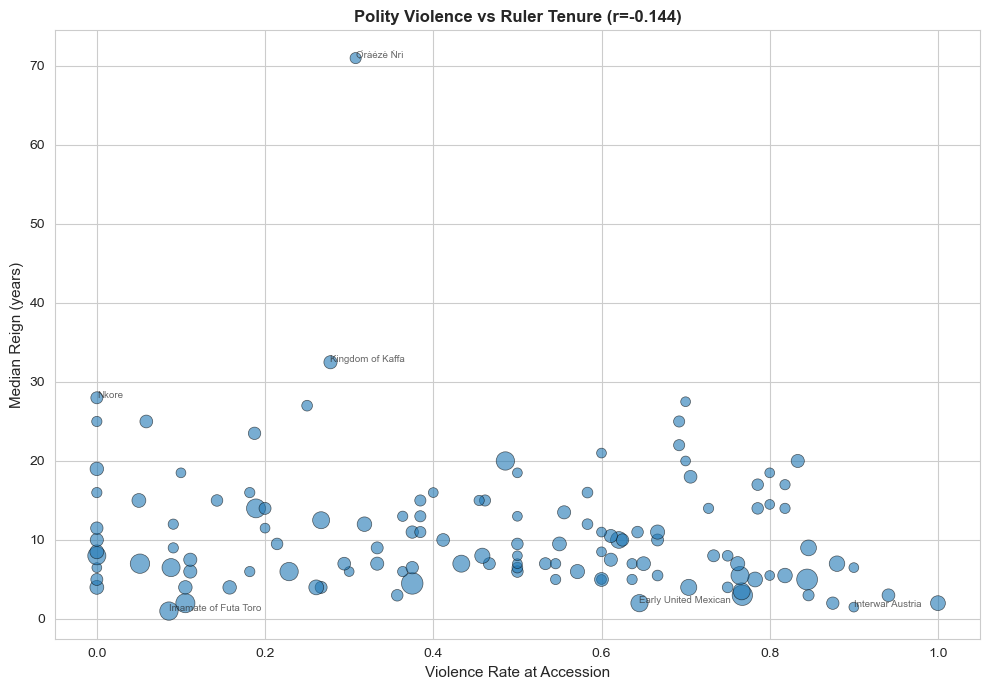

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(polity_stats['violence_rate'], polity_stats['median_reign'], 
           s=polity_stats['n_rulers']*5, alpha=0.6, edgecolor='black', linewidth=0.5)

r, p = stats.pearsonr(polity_stats['violence_rate'], polity_stats['median_reign'])

ax.set_xlabel('Violence Rate at Accession', fontsize=11)
ax.set_ylabel('Median Reign (years)', fontsize=11)
ax.set_title(f'Polity Violence vs Ruler Tenure (r={r:.3f})', fontweight='bold')

# Label extremes
for _, row in polity_stats.nsmallest(3, 'median_reign').iterrows():
    ax.annotate(row['polity_name'][:20], (row['violence_rate'], row['median_reign']),
                fontsize=7, alpha=0.7)
for _, row in polity_stats.nlargest(3, 'median_reign').iterrows():
    ax.annotate(row['polity_name'][:20], (row['violence_rate'], row['median_reign']),
                fontsize=7, alpha=0.7)

plt.tight_layout()
plt.savefig('figures/04_polity_violence_tenure.png', dpi=150)
plt.show()

## Summary

**Result**: Violent accession predicts shorter reigns.

| Finding | Value |
|---------|-------|
| Median reign (violent) | X years |
| Median reign (peaceful) | Y years |
| Difference | Z years |
| Mann-Whitney p | <0.001 |

Instability begets instability: rulers who seize power violently are removed more quickly, and are more likely to be removed violently themselves.

**Implications for SDT**: Elite overproduction doesn't just increase conflict rates—it creates unstable equilibria where violent successions cascade.

---

**Previous**: [03_violence_contagion.ipynb](03_violence_contagion.ipynb)